In [3]:
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install opencv-contrib-python==3.4.2.17
!pip install pandas
!pip install pillow
!pip install scikit-learn
!pip install scikit-image
!pip install scikit-optimize
!pip install shortuuid
!pip install torch
!pip install torchsummary
!pip install torchvision


     |████████████████████████████████| 30.6MB 94kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


     |████████████████████████████████| 81kB 2.3MB/s 


In [1]:
import copy
import csv
import cv2
import glob
import os
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from torchvision import models, transforms

def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C2"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Enable GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

## Split data
Generate random, stratified 80/20 split for training and validation sets

In [4]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [5]:
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))





### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [6]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Datasets

Given a directory of images and a CSV file of annotations, this defines a PyTorch Dataset which will load an image from disk and apply all configure transformations and return a tuple containing the image and label.


In [7]:
class SoybeanDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data_path, ann_df, transforms=None):
        """
        Args:
            data_path (string): path to images
            ann_df (string): pandas data frame containing file names and annotations
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        
        self.data = ann_df
        self.labels = np.asarray(self.data.iloc[:, 1])
        
        self.transforms = transforms

    def __getitem__(self, index):
        #print('index:', index)
        image_label = int(self.labels[index])
        img_path = os.path.join(self.data_path, self.data.file_name[index])

        img = Image.open(img_path)
        
        # Transform image
        if self.transforms is not None:
            img = self.transforms(img)
            
        # Return image and the label
        return img, image_label

    def __len__(self):
        return self.data.shape[0]


class SoybeanTestDatasetFolder(torch.utils.data.IterableDataset):
    def __init__(self, data_path, transforms=None):
        """
        Args:
            data_path (string): path to images
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_path = data_path
        self.transforms = transforms
        
        self.images = []
        
        for root, _, fnames in sorted(os.walk(data_path, followlinks=True)):
            for fname in sorted(fnames):
                path = fname
                if is_image_file(path):
                    self.images.append(path)

                                       
    def image_gen(self):
        for i in self.images:
            img_path = os.path.join(self.data_path, i)
            img = Image.open(img_path)
        
            # Transform image
            if self.transforms is not None:
                img = self.transforms(img)
                
            yield img
            

    def __iter__(self):
        return iter(self.image_gen())

    
    def __len__(self):
        return len(self.images)
    


class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_dataloader,
                 val_dataloader=None,
                 test_dataloader=None):
        self.class_weights = class_weights
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader


def compute_class_weights(df, y_col):
    """
    Returns a list of class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy(dtype=np.int32).flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return torch.tensor(weights, dtype=torch.float32).to(device)
    


### Common image transformations
These images transformations will apply to both train and validation data.

In [8]:
class SamplewiseCenterNormalize(object):

    def __init__(self):
        pass
    
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        
        return torch.div(torch.add(tensor, torch.mul(torch.mean(tensor), -1)), torch.std(tensor) + 1e-6)
        

    def __repr__(self):
        return self.__class__.__name__



DATA_TRANSFORMS = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), shear=10, scale=(1.0, 1.2)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    #transforms.RandomCrop(size=(480,640)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()

    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

TEST_DATA_TRANSFORMS = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # SamplewiseCenterNormalize()
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Train 0.80/Val 0.20 Split

In [9]:
def train_val_split_group(class_weights=None):
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
    train_dataset = SoybeanDataset(TRAIN_SPLIT_AUGMENTED_DATA_DIR, train_ann_df, transforms=DATA_TRANSFORMS)
    val_dataset = SoybeanDataset(VAL_SPLIT_DATA_DIR, val_ann_df, transforms=TEST_DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                                 batch_size=BATCH_SIZE,
                                                 pin_memory=True,
                                                 num_workers=16)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, val_dataloader, test_dataloader)


### Train 100%

Train with all the data in the `TrainData-C2` dataset 

In [10]:
def all_train_data_group(class_weights=None):
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)

    train_dataset = SoybeanDataset(TRAIN_DATA_AUGMENTED_DATA_DIR, ann_df, transforms=DATA_TRANSFORMS)
    test_dataset  = SoybeanTestDatasetFolder(TEST_DATA_DIR, transforms=TEST_DATA_TRANSFORMS)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   pin_memory=True, 
                                                   num_workers=16)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE,
                                                  pin_memory=True,
                                                  num_workers=0)
    
    return SoybeanDataGroup(class_weights, train_dataloader, None, test_dataloader)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [11]:
def get_model(n1, n2, dropout, batch_normalization=False):
    if batch_normalization:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16(pretrained=True) 

    # Freeze training for all layers
    for param in model.features.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d((1,1))
    
    # Replace the VGG16 classifier with a custom classifier for soybean wilting 
    model.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, n1, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n1, n2, bias=True),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(n2, 5, bias=True)
    )
    
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [12]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    """
    Trains the specified neural network model
    
    Args:
        model:         - neural network model to train
        criterion:     - loss function
        optimizer:     - gradient descent optimization algorithm
        dataloaders:   - dict of DataLoaders for training and validation data
        num_epochs:    - number of epochs to train model
    Returns:
        model   - trained model with weights from the epoch with the best validation accuracy
        history - dict of training and validation loss and accuracy for all epochs
    """
    since = time.time()
    
    # summary(model, input_size=(3, 224, 224))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train': {'loss': [], 'acc': []}}
    phases = ['train']
    if ('val' in dataloaders and dataloaders['val'] is not None):
        phases += ['val']
        history['val'] = {'loss': [], 'acc': []}
    
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and optionally, a validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            phase_start = time.time()

            sample_count = 0
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:               
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        nn.utils.clip_grad_value_(model.parameters(), 0.5)
                        optimizer.step()

                # statistics
                sample_count += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels.data.view_as(preds)).cpu().sum()
            
            print('Num samples', sample_count)
            
            epoch_loss = running_loss / sample_count
            epoch_acc = running_corrects.double() / sample_count
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            
            phase_end = time.time()
            phase_elapsed = phase_end - phase_start

            print('{} {} loss: {:.4f} accuracy: {:.4f}'.format(
                phase, str(timedelta(seconds=phase_elapsed)), epoch_loss, epoch_acc))

            # deep copy the model
            if ('val' not in phases or phase == 'val') and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print('Elapsed time: {}'.format(str(timedelta(seconds=epoch_elapsed))))
        
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Train models

In [21]:
BATCH_SIZE = 32

def get_sample_count(dataset, sampler):
    if (sampler is not None):
        return len(sampler)
    elif (dataset is not None):
        return len(dataset)
    else:
        return None
    

def train(model, group, num_epochs=20):
    criterion = nn.CrossEntropyLoss(weight=group.class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
    
    dataloaders = {
        'train': group.train_dataloader,
        'val': group.val_dataloader
    }
 
    model_trained, history = train_model(model, criterion, optimizer, dataloaders, num_epochs)
    
    
    return model_trained, history


def get_all_labels(loader):
    all_labels = torch.tensor([], dtype=torch.long)
    for batch in loader:
        _, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_labels


def plot_metrics(model, history, train_dataloader, val_dataloader=None):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    # Create count of the number of epochs
    epoch_count = range(1, len(history['train']['loss']) + 1)

    # Visualize loss history
    plt.plot(epoch_count, history['train']['loss'], 'g-')
    loss_legend = ['Training Loss']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['loss'], 'b-')
        loss_legend += ['Validation Loss']
        
    plt.legend(loss_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Visualize accuracy history
    plt.plot(epoch_count, history['train']['acc'], 'g-')
    acc_legend = ['Training Accuracy']
    
    if ('val' in history and history['val'] is not None):
        plt.plot(epoch_count, history['val']['acc'], 'b-')
        acc_legend += ['Validation Accuracy']
    
    plt.legend(acc_legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    
    # Training confusion matrix
    train_predictions = predict(model, train_dataloader).cpu().numpy()
    
    print("Training Confusion Matrix")
    print("-" * 30)
    print_confusion_matrix(get_all_labels(train_dataloader).cpu().numpy(),
                           train_predictions)
        
    # Validation confusion matrix
    if val_dataloader is not None:
        val_predictions = predict(model, val_dataloader).cpu().numpy()
        
        print("Validation Confusion Matrix")
        print("-" * 30)
        print_confusion_matrix(get_all_labels(val_dataloader).cpu().numpy(),
                               val_predictions)
        

def train_and_test(model, group, num_epochs=60):
    model_trained, history = train(model, group, num_epochs)
    
    # Plot history metrics
    plot_metrics(model_trained, history, group.train_dataloader, group.val_dataloader)
    
    # Classify test data
    return predict(model_trained, group.test_dataloader)


def predict(model, dataloader):
    predictions = torch.tensor([], dtype=torch.long).to(device)
    
    with torch.no_grad():
        for data in dataloader:
            if (type(data) is list):
                images = data[0].to(device)
            else:
                images = data.to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions = torch.cat((predictions, predicted))

    return predictions

def one_hot_encode_predictions(predictions, csvfile):

    #for k, v in sorted(Counter(predictions).items()): 
    #    print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in predictions]
    for i in range(len(one_hots)):
        pred = predictions[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    confusion_matrix = np.zeros((5, 5))
    labels = [0, 1, 2, 3, 4]
    for i in range(len(labels)):
        for j in range(len(labels)):
            ground_truth = y==labels[i]
            prediction = y_hat==labels[j]
            confusion_matrix[i, j] = sum(np.bitwise_and(ground_truth, prediction))
    df = pd.DataFrame(confusion_matrix, dtype=int)
    display(df)

### Train and Test - 80/20 Split

In [0]:
#model = get_model(1024, 128, 0.5).to(device)
#y_hat_test = train_and_test(model, train_val_split_group(), num_epochs=1)
#predictions_file = "predict_c2_g1_" + shortuuid.uuid()
#print('predictions file:', predictions_file)
#predict_whole_images(y_hat_test, 5, 5, predictions_file)

### Train and Test - All Train Data


In [14]:
#model = get_model(1024, 128, 0.1).to(device)
#y_hat_test = train_and_test(model, group_3())
#predict_whole_images(y_hat_test, 5, 5, 'predictions_c2_g3.csv')


## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [20]:
def run_trial(name, model, class_weights=None, num_epochs=40):
    y_hat_test = train_and_test(model, train_val_split_group(class_weights), num_epochs)
    predictions_file = "predict_c2_whole_{}_{}.csv".format(name, shortuuid.uuid())
    print('predictions file:', predictions_file)
    one_hot_encode_predictions(y_hat_test, predictions_file)

    print('Test distribution:')
    print(y_hat_test.bincount())
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/0
----------
Num samples 2000
train 0:00:25.095676 loss: 1.3948 accuracy: 0.3950
Num samples 255
val 0:00:03.917939 loss: 1.2468 accuracy: 0.3725
Elapsed time: 0:00:29.016444

Training complete in 0m 29s
Best acc: 0.372549

Metrics
----------


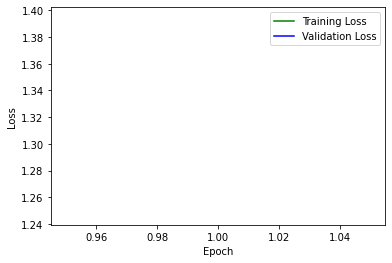

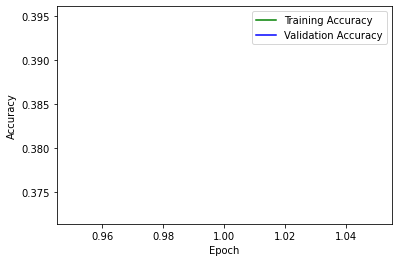

Training Confusion Matrix
------------------------------


,0,1,2,3,4
0,0,393,0,0,7
1,0,265,0,0,135
2,0,249,0,0,151
3,0,91,0,0,309
4,0,3,0,0,397


Validation Confusion Matrix
------------------------------


,0,1,2,3,4
0,0,98,0,0,0
1,0,59,0,0,7
2,0,21,0,0,5
3,0,17,0,0,9
4,0,3,0,0,36


predictions file: predict_c2_whole_h1_aMWNKG4HL6wZfhH4CZM8XN.csv
Finished generating predictions to predict_c2_whole_h1_aMWNKG4HL6wZfhH4CZM8XN.csv
Test distribution:
tensor([  1, 140,   0,   0,  59], device='cuda:0')


In [22]:
model = get_model(1024, 128, 0.5).to(device)
y_hat_test = run_trial("h1", model, num_epochs=1)

In [34]:
#group = train_val_split_group()
#y_hat_test = predict(model, group.test_dataloader)
#predictions_file = "predict_c2_whole_{}_{}.csv".format("h1", shortuuid.uuid())
#print('predictions file:', predictions_file)
#one_hot_encode_predictions(y_hat_test, predictions_file)
y_hat_test.bincount()

tensor([39, 99,  0,  0, 62], device='cuda:0')

In [30]:
group = train_val_split_group()
len(group.test_dataloader)

Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')


200

#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [0]:
model = get_model(2048, 256, 0.5).to(device)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [0]:
model = get_model(512, 64, 0.5).to(device)
run_trial("h3", model)

#### H4: Best from above, dropout 0.25

* DNN Structure: 
* Dropout: 0.25
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [0]:
model = get_model(n1, n2, 0.25).to(device)
run_trial("h4", model)

#### H5: Best from above, dropout 0.1

* DNN Structure: 
* Dropout: 0.1
* Class weights: [1,1,1,1,1]
* Batch normalization: no


In [0]:
model = get_model(n1, n2, 0.1).to(device)
run_trial("h5", model)

#### H6: Best from above, skewed class weights

* DNN Structure: 
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


Reading annotations...
Using class weights: tensor([1., 1., 5., 5., 1.], device='cuda:0')
Epoch 0/19
----------
Num samples 2000
train 0:00:25.160152 loss: 1.4062 accuracy: 0.2540
Num samples 255
val 0:00:03.963046 loss: 1.5221 accuracy: 0.3412
Elapsed time: 0:00:29.125959

Epoch 1/19
----------
Num samples 2000
train 0:00:26.275689 loss: 1.4281 accuracy: 0.2745
Num samples 255
val 0:00:04.080608 loss: 1.3879 accuracy: 0.5882
Elapsed time: 0:00:30.359353

Epoch 2/19
----------
Num samples 2000
train 0:00:26.560632 loss: 1.3073 accuracy: 0.3050
Num samples 255
val 0:00:03.936842 loss: 1.2903 accuracy: 0.5608
Elapsed time: 0:00:30.498105

Epoch 3/19
----------
Num samples 2000
train 0:00:25.374650 loss: 1.1934 accuracy: 0.3550
Num samples 255
val 0:00:03.897209 loss: 1.2750 accuracy: 0.5922
Elapsed time: 0:00:29.274799

Epoch 4/19
----------
Num samples 2000
train 0:00:25.128281 loss: 1.1958 accuracy: 0.3665
Num samples 255
val 0:00:03.830451 loss: 1.1948 accuracy: 0.6549
Elapsed time: 0

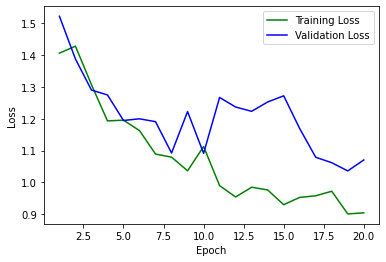

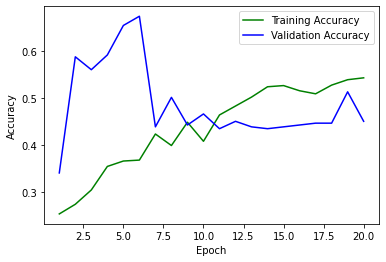

Training Confusion Matrix
------------------------------


,0,1,2,3,4
0,341,23,34,2,0
1,202,67,70,42,19
2,124,16,139,71,50
3,21,2,61,133,183
4,0,0,1,6,393


Validation Confusion Matrix
------------------------------


,0,1,2,3,4
0,83,15,0,0,0
1,23,40,0,3,0
2,8,13,0,4,1
3,0,9,0,15,2
4,0,0,0,5,34


predictions file: predict_c2_whole_h6_gu7n3deKm6MnNTA4ex2DnL.csv
Finished generating predictions to predict_c2_whole_h6_gu7n3deKm6MnNTA4ex2DnL.csv
Test distribution:
tensor([66, 78,  0,  3, 53], device='cuda:0')


In [25]:
model = get_model(1024, 128, 0.5).to(device)
y_hat_test = run_trial("h6", model, class_weights=torch.tensor([1., 1., 5., 5., 1.]).to(device), num_epochs=20)

#### H6b

Reading annotations...
Using class weights: tensor([0.7500, 0.9000, 5.0000, 4.0000, 0.7500], device='cuda:0')
Epoch 0/19
----------
Num samples 2000
train 0:00:24.899133 loss: 1.3880 accuracy: 0.2675
Num samples 255
val 0:00:03.917353 loss: 1.5874 accuracy: 0.2824
Elapsed time: 0:00:28.819566

Epoch 1/19
----------
Num samples 2000
train 0:00:25.169312 loss: 1.4463 accuracy: 0.2420
Num samples 255
val 0:00:03.898894 loss: 1.4376 accuracy: 0.3725
Elapsed time: 0:00:29.071236

Epoch 2/19
----------
Num samples 2000
train 0:00:25.012767 loss: 1.2669 accuracy: 0.2835
Num samples 255
val 0:00:03.941735 loss: 1.3323 accuracy: 0.5922
Elapsed time: 0:00:28.957411

Epoch 3/19
----------
Num samples 2000
train 0:00:25.136180 loss: 1.2235 accuracy: 0.3175
Num samples 255
val 0:00:03.857179 loss: 1.2991 accuracy: 0.4235
Elapsed time: 0:00:28.993968

Epoch 4/19
----------
Num samples 2000
train 0:00:25.015122 loss: 1.1811 accuracy: 0.3370
Num samples 255
val 0:00:03.836164 loss: 1.2176 accuracy: 0.

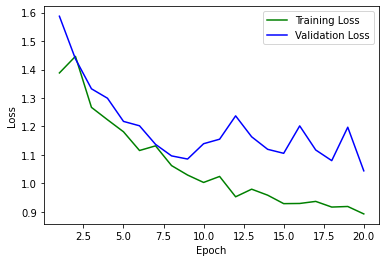

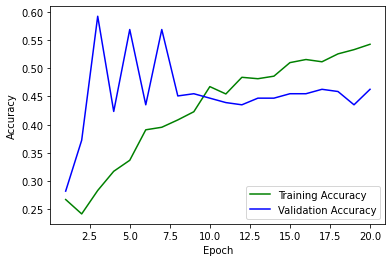

Training Confusion Matrix
------------------------------


,0,1,2,3,4
0,95,0,303,2,0
1,63,2,283,35,17
2,21,0,283,46,50
3,2,0,142,116,140
4,0,0,4,12,384


Validation Confusion Matrix
------------------------------


,0,1,2,3,4
0,98,0,0,0,0
1,55,5,0,6,0
2,17,0,3,5,1
3,8,0,3,13,2
4,0,0,0,7,32


predictions file: predict_c2_whole_h6_UV26TynKikAf5JaiJGgtQq.csv
Finished generating predictions to predict_c2_whole_h6_UV26TynKikAf5JaiJGgtQq.csv
Test distribution:
tensor([131,   5,   6,  10,  48], device='cuda:0')


In [36]:
model = get_model(1024, 128, 0.5).to(device)
y_hat_test = run_trial("h6", model, class_weights=torch.tensor([0.75, 0.9, 5., 4., 0.75]).to(device), num_epochs=20)

#### H7: Best from above, batch normalization

* DNN Structure: 
* Dropout: 0.5
* Class weights: 
* Batch normalization: yes


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/jeremy/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth



Reading annotations...
Computing class weights...
tensor([1., 1., 1., 1., 1.], device='cuda:0')
Epoch 0/39
----------
Num samples 2000
train 0:00:28.964884 loss: 1.5714 accuracy: 0.2940
Num samples 255
val 0:00:04.429382 loss: 1.7407 accuracy: 0.1608
Elapsed time: 0:00:33.400800

Epoch 1/39
----------
Num samples 2000
train 0:00:29.171897 loss: 1.5616 accuracy: 0.2910
Num samples 255
val 0:00:04.146062 loss: 1.3552 accuracy: 0.4157
Elapsed time: 0:00:33.323944

Epoch 2/39
----------
Num samples 2000
train 0:00:29.001632 loss: 1.4520 accuracy: 0.3410
Num samples 255
val 0:00:04.143731 loss: 1.0320 accuracy: 0.5529
Elapsed time: 0:00:33.152327

Epoch 3/39
----------
Num samples 2000
train 0:00:28.774288 loss: 1.3684 accuracy: 0.3965
Num samples 255
val 0:00:04.280967 loss: 0.9445 accuracy: 0.5686
Elapsed time: 0:00:33.062075

Epoch 4/39
----------
Num samples 2000
train 0:00:29.166832 loss: 1.3046 accuracy: 0.4190
Num samples 255
val 0:00:04.256273 loss: 0.9127 accuracy: 0.5608
Elapsed 

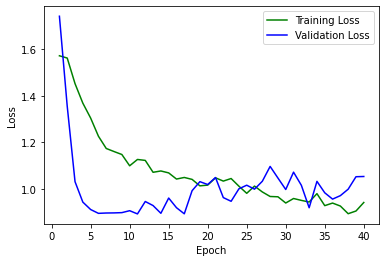

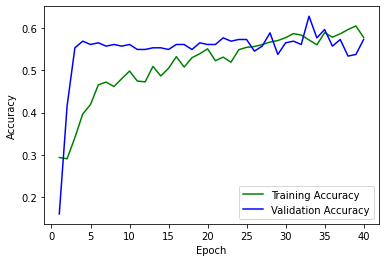

Training Confusion Matrix
------------------------------


,0,1,2,3,4
0,398,2,0,0,0
1,252,130,15,3,0
2,110,67,175,33,15
3,19,30,86,190,75
4,0,0,0,13,387


Validation Confusion Matrix
------------------------------


,0,1,2,3,4
0,98,0,0,0,0
1,51,15,0,0,0
2,15,7,3,0,1
3,8,4,2,7,5
4,0,0,0,2,37


predictions file: predict_c2_whole_h7_b2Xsg5dVwP7rRo2LiyTA9k.csv
Finished generating predictions to predict_c2_whole_h7_b2Xsg5dVwP7rRo2LiyTA9k.csv
Test distribution:
tensor([112,  29,   0,   3,  56], device='cuda:0')


tensor([0, 4, 4, 0, 1, 4, 1, 0, 0, 0, 3, 4, 4, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 4, 0, 0, 0, 4, 0, 4, 1, 1, 4, 4, 0, 0, 0, 1, 4, 1, 0, 0, 4, 1, 1,
        0, 0, 0, 0, 0, 4, 4, 4, 0, 4, 1, 0, 0, 0, 0, 1, 0, 1, 3, 0, 0, 4, 4, 0,
        0, 4, 0, 4, 4, 1, 1, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 0, 1, 0, 0, 0,
        0, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 0, 0, 1, 0, 4, 0, 4, 4, 0, 0, 0, 4,
        0, 0, 0, 4, 3, 0, 4, 4, 1, 1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0,
        0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4,
        4, 0, 4, 4, 0, 0, 4, 0, 1, 4, 4, 4, 1, 0, 4, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        4, 0, 4, 0, 4, 0, 0, 0], device='cuda:0')

In [37]:
model = get_model(1024, 128, 0.5, batch_normalization=True).to(device)
run_trial("h7", model)

#### Summary: Best hyperparameters

In [0]:
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.1


## Train with all C2 data and optimal hyperparameters

In [0]:
model = get_model(optimal_n1, optimal_n2, optimal_d).to(device)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=40)
predictions_file = "predict_c2_whole_{}.csv".format(shortuuid.uuid())
print('predictions file:', predictions_file)
one_hot_encode_predictions(y_hat_test, predictions_file)

In [0]:
torch.set_printoptions(profile="full")
print(y_hat_test)
torch.set_printoptions(profile="default")

### Save model

In [0]:
torch.save(model.state_dict(), 'cnn_pytorch_c2_whole.pt')